# AirBnB : Part 2, Exploratory Data Analysis

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd

import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.grid_search import GridSearchCV

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale,LabelEncoder

from xgboost import XGBClassifier
from utils import rstr,distance

/home/ramon/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationW

### Add frequency reviews and distance to highlights

In [2]:
df_id = pd.read_csv('../../data/listing_cleansed.csv')
#df_listing = pd.read_csv('../../data/listing_cleansed.csv')

#df_listing = pd.read_csv('../../data/listing_with_reviews_PCA.csv')
df_listing = pd.read_csv('../../data/df_listing_high_renter_with_pic_data.csv')
df_listing= pd.merge(df_listing,df_id[['listing_id','host_id']],on='listing_id')
df_listing.host_id.isnull().sum()

0

In [3]:
df_id.last_review.min()


80.0

In [3]:
df_review_with_lang = pd.read_csv('../../data/reviews_with_lang.csv',index_col=0)

In [4]:
df_review_with_lang.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,7878281,46630032,2015-09-12,39579628,Roberto,"Host molto gentile e disponibile, l'appartamen...",it
1,7878281,50115386,2015-10-09,45018962,Rotem,"AMAZING hosting, we arrived to Benita's appart...",en
2,7878281,54012898,2015-11-15,47456471,Jochen,"Sehr schöne und ideal gelegene Wohnung, ideal ...",de
3,7878281,58376102,2016-01-02,6789115,Nicola,"This apartment was beautiful, spacious, warm a...",en
4,7878281,71814574,2016-04-28,63494941,Claudio,BENITA AND KLEMENS WERE VERY KIND WITH US. THE...,en


In [5]:
groupy_lang_review = df_review_with_lang.groupby(['listing_id','language'])[['id']].count().unstack().fillna(0)
groupy_lang_review.columns = groupy_lang_review.columns.droplevel()
groupy_lang_review = groupy_lang_review.reset_index()
groupy_lang_review=groupy_lang_review.astype(int)

In [6]:
df_listing = pd.merge(df_listing,groupy_lang_review,on='listing_id')

In [7]:
df_reviews_freq=pd.read_csv('../../data/reviews_frequency.csv')
df = pd.merge(df_listing,df_reviews_freq,on='listing_id')

In [8]:
df_listing.shape

(3196, 642)

In [9]:
coord_brandenburg_tor = (52.516849,13.377661)
def distance_highlight(x):
    return distance(coord_brandenburg_tor,x)
    

In [10]:

df['coordinate']=list(zip(df.latitude, df.longitude))
df['distance_brandenburg_tor'] = df['coordinate'].apply(distance_highlight)

df['listings_per_host']=df.groupby(["host_id"])["listing_id"].transform("count")

df = pd.concat([df,pd.get_dummies(df.text_language,prefix='language_text_')],axis=1)

df['is_multi_host']=( df.listings_per_host>1)*1

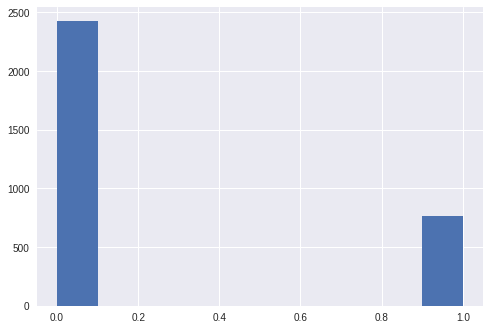

In [11]:
df.is_multi_host.hist()

### Filter on listings with high reviews number

In [12]:
df = df[df.last_review<200]
df = df[df.number_of_reviews>2]
df = df[~df.review_scores_accuracy.isnull()]


### Fill the missing data

In [13]:
columns_fill_na_with_mean = [u'bathrooms', u'bedrooms', u'beds', u'host_since',
       u'host_listings_count','host_response_time','host_response_rate','review_scores_value','review_scores_cleanliness','review_scores_communication','review_scores_location']

df[columns_fill_na_with_mean]= df[columns_fill_na_with_mean].fillna(df[columns_fill_na_with_mean].mean())

In [14]:
df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data[df_missing_data.missing_percent>0]

,missing_percent
text_notes,58.421630
text_access,47.679942
text_interaction,45.305079
text_neighborhood_overview,41.834125
text_host_about,39.970771
text_house_rules,33.321155
text_transit,32.078919
text_space,21.556449
text_summary,5.261235
text_name,0.182682


In [15]:
df.to_csv('../../data/listing_for_EDA.csv',index=None)

## Correlation with target

In [16]:
TARGET = 'host_listings_count'

### Columns to exclude

In [17]:
cols_amenities = [col for col in df.columns if 'amenities' in col]
cols_review_PC = [col for col in df.columns if 'reviews_PC' in col]
cols_picture_PC = [col for col in df.columns if 'pictures_PC' in col]
cols_language_text = [col for col in df.columns if 'language_text' in col]



COLS_EXCLUDE = cols_amenities+cols_review_PC+cols_picture_PC+cols_language_text+['listing_id','host_id','listings_per_host']

COLS_INCLUDE =['reviews_PC_4', 'reviews_PC_3','reviews_PC_8','amenities__Elevatorinbuilding', u'amenities__TV', u'beds',
       u'reviews_PC_13',u'amenities__Shampoo', u'amenities__Laptopfriendlyworkspace','pictures_PC_1']

COLS_EXCLUDE = list(set(COLS_EXCLUDE)-set(COLS_INCLUDE))

In [18]:
df_corr = df.corr()[TARGET]
df_corr = pd.DataFrame(df_corr)
df_corr['corr_abs'] = np.abs(df_corr[TARGET])
df_corr = df_corr.sort_values(by='corr_abs',ascending=False)
df_corr.head(30)

,host_listings_count,corr_abs
host_listings_count,1.000000,1.000000
listings_per_host,0.704505,0.704505
is_multi_host,0.429588,0.429588
instant_bookable,0.234392,0.234392
review_scores_communication,-0.214009,0.214009
reviews_PC_4,0.184697,0.184697
reviews_PC_3,-0.178023,0.178023
review_scores_accuracy,-0.176133,0.176133
review_scores_rating,-0.175830,0.175830
availability_365_previous_month,0.168126,0.168126


## Linear Model and R-squared

In [19]:
TARGET_CLASSIFICATION ='is_multi_host'
y = df[TARGET_CLASSIFICATION]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

X = df.drop([TARGET_CLASSIFICATION,'host_listings_count']+COLS_EXCLUDE,axis=1).select_dtypes(include=numerics)

### Train test split

In [20]:
def balanced_subsample(y, size=None):

    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample

In [21]:
rebalanced_index = balanced_subsample(y)

In [22]:
X,y = X.loc[rebalanced_index],y.loc[rebalanced_index]

In [23]:
y.value_counts()

1    697
0    697
Name: is_multi_host, dtype: int64

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,stratify=y)

### Logistic Regression

In [25]:
lm = LogisticRegression(C=1e5)
lm.fit(X_train,y_train)
prediction = lm.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

[[ 99  41]
 [ 24 115]]
             precision    recall  f1-score   support

          0       0.80      0.71      0.75       140
          1       0.74      0.83      0.78       139

avg / total       0.77      0.77      0.77       279



### Random Forest

In [26]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
prediction = rf.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

[[111  29]
 [ 57  82]]
             precision    recall  f1-score   support

          0       0.66      0.79      0.72       140
          1       0.74      0.59      0.66       139

avg / total       0.70      0.69      0.69       279



### XGB

In [27]:
params = {
    'max_depth':[9],
    'min_child_weight':[2],
    'learning_rate' :[0.1],
    'gamma':[0.0],
    'n_estimators':[100]
}

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=-1,scoring="recall")
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_

clf = XGBClassifier()

best_clf = cv_optimize(clf,params,X_train,y_train)

print(best_clf)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=2, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [28]:
prediction = best_clf.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

[[110  30]
 [ 25 114]]
             precision    recall  f1-score   support

          0       0.81      0.79      0.80       140
          1       0.79      0.82      0.81       139

avg / total       0.80      0.80      0.80       279



In [29]:
y_train.value_counts()

1    558
0    557
Name: is_multi_host, dtype: int64

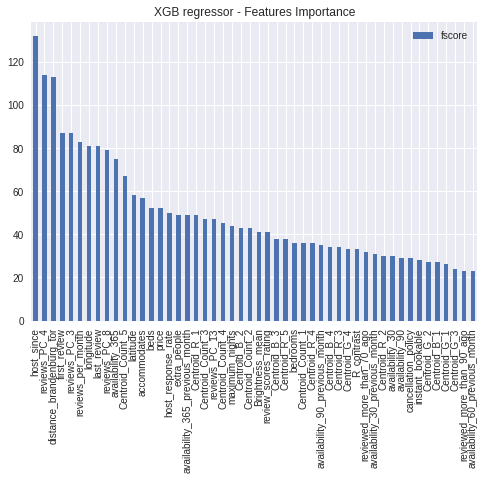

In [30]:
features_weights = pd.DataFrame.from_dict(best_clf.booster().get_fscore(),orient="index")
features_weights.columns = ['fscore']

features_weights.sort_values(by='fscore',ascending=False).head(50).plot(kind='bar',title='XGB regressor - Features Importance')

In [31]:
features_weights.sort_values(by='fscore',ascending=False).head(20)

,fscore
host_since,132
reviews_PC_4,114
distance_brandenburg_tor,113
first_review,87
reviews_PC_3,87
reviews_per_month,83
longitude,81
last_review,81
reviews_PC_8,79
availability_365,75


## K-Means clustering

In [32]:
#np.random.seed(42)

data = scale(X)

n_samples, n_features = X.shape
n_digits = len(np.unique(y))
labels = y


sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')

n_digits: 2, 	 n_samples 1394, 	 n_features 188
_______________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette
k-means++   0.49s    225270   0.082   0.090   0.086   0.097   0.082    0.082
   random   0.35s    225254   0.061   0.069   0.065   0.068   0.061    0.077
PCA-based   0.03s    225259   0.055   0.064   0.059   0.060   0.055    0.089
_______________________________________________________________________________


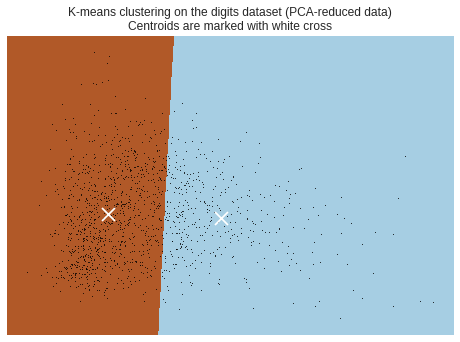

In [33]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)



# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()